In [2]:
import sys
sys.path.append('..')
from cmost_hdr import magnitude_to_count_rate, count_rate_to_electron_rate, get_signal, get_snr, perform_hdr_simple

import numpy as np
import astropy.units as u
import astropy.constants as cr
import matplotlib
import matplotlib.pyplot as plt

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

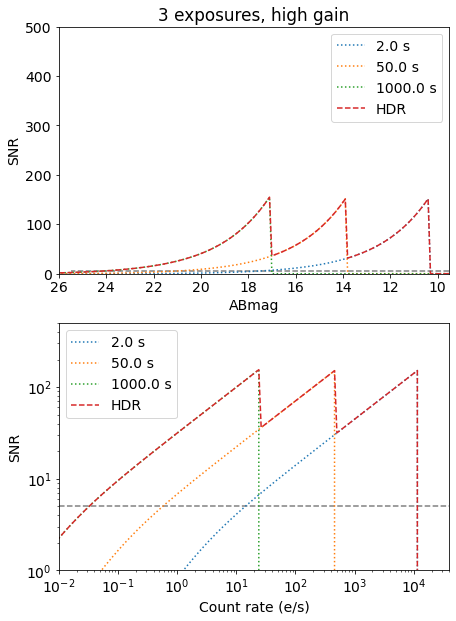

In [2]:
# Define experiment setup, including band and gain mode
b = 'fuv'
g = 'high'
mags = np.arange(9,28,0.1) * u.ABmag
exp_times = [2.,50.,1000.] * u.s
labels = [str(t) for t in exp_times]

count_rate = magnitude_to_count_rate(mags, band=b)
cr_psf = count_rate / 4
e_rate = count_rate_to_electron_rate(cr_psf)

signal, saturated = get_signal(cr_psf, exp_times, gain_mode=g)
snr = get_snr(cr_psf, exp_times, band=b, gain_mode=g)
hdr_snr = perform_hdr_simple(snr, saturated, exp_times)

# Plot input magnitude vs SNR
plt.figure(figsize=[7,10])
plt.subplot(211)
plt.title('3 exposures, high gain')
plt.hlines(5,9.5,25.5,color='grey',ls='--')
for i, t in enumerate(exp_times):
    plt.plot(mags,snr[i],ls='dotted',label=labels[i])
plt.plot(mags,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('ABmag')
plt.ylabel('SNR')
plt.xlim([26,9.5])
plt.ylim([0,500])

# Plot input count rate vs SNR
plt.subplot(212)
plt.loglog()
plt.hlines(5,0.01,40000,color='grey',ls='--')
for i, t in enumerate(exp_times):
    plt.plot(e_rate,snr[i],ls='dotted',label=labels[i])
plt.plot(e_rate,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('Count rate (e/s)')
plt.ylabel('SNR')
plt.xlim([0.01,40000])
plt.ylim([1,500])
plt.show()

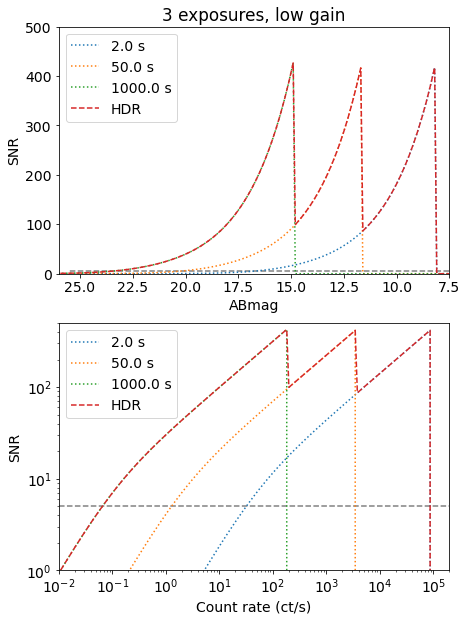

In [10]:
# Define experiment setup, including band and gain mode
b = 'fuv'
g = 'low'
mags = np.arange(7,28,0.1) * u.ABmag
exp_times = [2.,50.,1000.] * u.s
labels = [str(t) for t in exp_times]

count_rate = magnitude_to_count_rate(mags, band=b)
cr_psf = count_rate / 4
e_rate = count_rate_to_electron_rate(cr_psf)

signal, saturated = get_signal(cr_psf, exp_times, gain_mode=g)
snr = get_snr(cr_psf, exp_times, band=b, gain_mode=g)
hdr_snr = perform_hdr_simple(snr, saturated, exp_times)

# Plot input magnitude vs SNR
plt.figure(figsize=[7,10])
plt.subplot(211)
plt.title('3 exposures, low gain')
plt.hlines(5,7.5,25.5,color='grey',ls='--')
for i, t in enumerate(exp_times):
    plt.plot(mags,snr[i],ls='dotted',label=labels[i])
plt.plot(mags,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('ABmag')
plt.ylabel('SNR')
plt.xlim([26,7.5])
plt.ylim([0,500])

# Plot input count rate vs SNR
plt.subplot(212)
plt.loglog()
plt.hlines(5,0.01,200000,color='grey',ls='--')
for i, t in enumerate(exp_times):
    plt.plot(e_rate,snr[i],ls='dotted',label=labels[i])
plt.plot(e_rate,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('Count rate (e/s)')
plt.ylabel('SNR')
plt.xlim([0.01,200000])
plt.ylim([1,500])
plt.show()

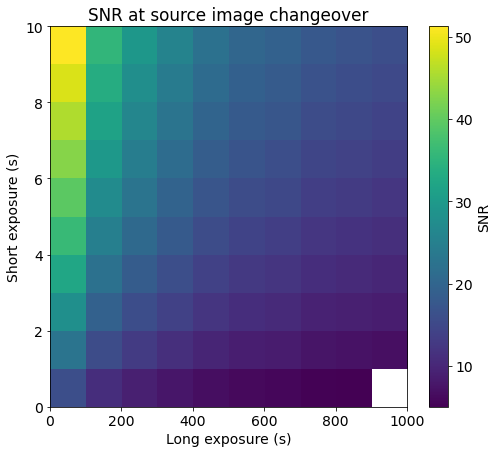

In [11]:
# Different time combinations
g = 'high'
long_exp = [100,200,300,400,500,600,700,800,900,1000] * u.s
short_exp = [1,2,3,4,5,6,7,8,9,10] * u.s

min_snr_arr = np.zeros((len(long_exp),len(short_exp)))
for i, l in enumerate(long_exp):
    for j, s in enumerate(short_exp):
        this_exp_times = [s,l] * u.s
        
        signal, saturated = get_signal(cr_psf, this_exp_times, gain_mode=g)
        snr = get_snr(cr_psf, this_exp_times, band=b, gain_mode=g)
        hdr_snr = perform_hdr_simple(snr, saturated, this_exp_times)
        
        h = hdr_snr[0]
        discont_index = -1
        for k, hs in enumerate(hdr_snr):
            
            # Find the SNR discontinuity
            if (hs > h) & (h > 0):
                snr_jump = h
                discont_index = k-1
                h = 0
            elif(discont_index < 0):
                h = hs
                
        min_snr_arr[j,i] = snr_jump
        
min_snr_arr[min_snr_arr < 5] = np.nan
        
plt.figure(figsize=[8,7])
plt.title('SNR at source image changeover')
plt.imshow(min_snr_arr,origin='lower',extent=[0,1000,0,10],aspect='auto')
plt.xlabel('Long exposure (s)')
plt.ylabel('Short exposure (s)')
plt.colorbar(label='SNR')
plt.show()

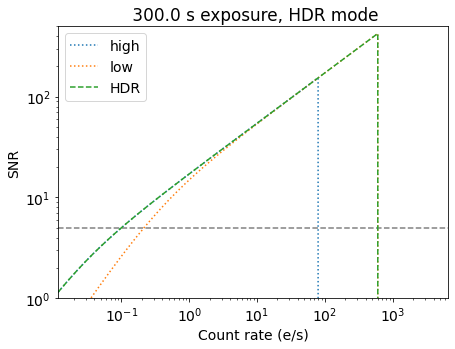

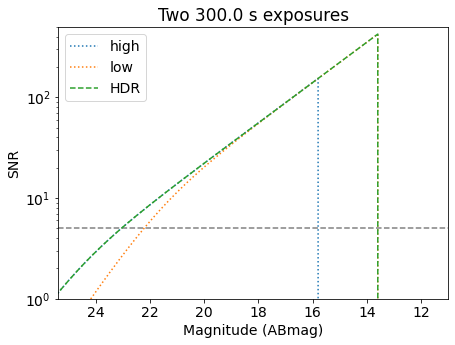

In [14]:
# Try two exposures of same duration but with different gain modes
b = 'fuv'
mags = np.arange(11,25.5,0.1) * u.ABmag
count_rate = magnitude_to_count_rate(mags, band=b)
cr_psf = count_rate / 4
e_rate = count_rate_to_electron_rate(cr_psf)

gains = ['high','low']
sorting = np.array([2,1]) # A little hack to make sure exposures are sorted in the order we want
exp_time = [300.] * u.s

signals = np.zeros((len(gains),len(cr_psf)))
saturated = np.full((len(gains),len(cr_psf)), False)
snr = np.zeros((len(gains),len(cr_psf)))
for i, g in enumerate(gains):
    sig, sat = get_signal(cr_psf, exp_time, gain_mode=g)
    s = get_snr(cr_psf, exp_time, band=b, gain_mode=g)
    
    signals[i] = sig
    saturated[i] = sat
    snr[i] = s

hdr_snr = perform_hdr_simple(snr, saturated, sorting)

# Plot input count rate vs SNR
plt.figure(figsize=[7,5])
plt.title(' {} exposure, HDR mode'.format(exp_time[0]))
plt.loglog()
plt.hlines(5,e_rate[-1].value,e_rate[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(e_rate,snr[i],ls='dotted',label=g)
plt.plot(e_rate,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('Count rate (e/s)')
plt.ylabel('SNR')
plt.xlim([e_rate[-1].value,e_rate[0].value])
plt.ylim([1,500])
plt.show()

plt.figure(figsize=[7,5])
plt.title('Two {} exposures'.format(exp_time[0]))
plt.semilogy()
plt.hlines(5,mags[-1].value,mags[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(mags,snr[i],ls='dotted',label=g)
plt.plot(mags,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('Magnitude (ABmag)')
plt.ylabel('SNR')
plt.xlim([mags[-1].value,mags[0].value])
plt.ylim([1,500])
plt.show()

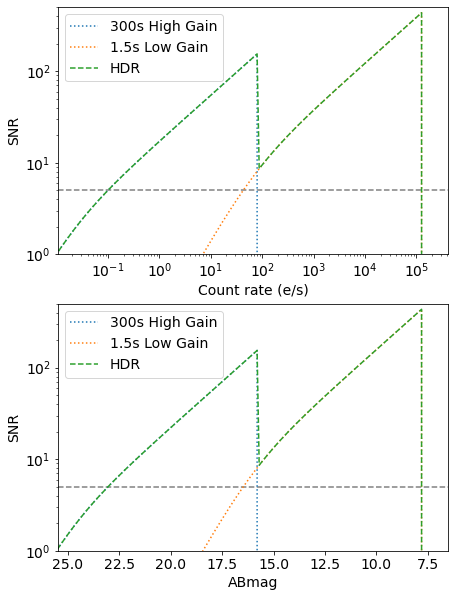

In [16]:
# Try two exposures of different durations and different gain modes
b = 'fuv'
mags = np.arange(6.5,25.6,0.1) * u.ABmag
count_rate = magnitude_to_count_rate(mags, band=b)
cr_psf = count_rate / 4
e_rate = count_rate_to_electron_rate(cr_psf)

gains = ['high','low']
exp_times = [300., 1.5] * u.s
labels = ['300s High Gain','1.5s Low Gain']

signals = np.zeros((len(gains),len(cr_psf)))
saturated = np.full((len(gains),len(cr_psf)), False)
snr = np.zeros((len(gains),len(cr_psf)))
for i, g in enumerate(gains):
    sig, sat = get_signal(cr_psf, [exp_times[i]], gain_mode=g)
    s = get_snr(cr_psf, [exp_times[i]], band=b, gain_mode=g)
    
    signals[i] = sig
    saturated[i] = sat
    snr[i] = s

hdr_snr = perform_hdr_simple(snr, saturated, exp_times)

# Plot input magnitude vs SNR
plt.figure(figsize=[7,10])
plt.subplot(211)
plt.loglog()
plt.hlines(5,e_rate[-1].value,e_rate[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(e_rate,snr[i],ls='dotted',label=labels[i])
plt.plot(e_rate,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('Count rate (e/s)')
plt.ylabel('SNR')
plt.xlim([e_rate[-1].value,e_rate[0].value])
plt.ylim([1,500])

# Plot input count rate vs SNR
plt.subplot(212)
#plt.figure(figsize=[7,5])
plt.semilogy()
plt.hlines(5,mags[-1].value,mags[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(mags,snr[i],ls='dotted',label=labels[i])
plt.plot(mags,hdr_snr,ls='--',label='HDR')
plt.legend()
plt.xlabel('ABmag')
plt.ylabel('SNR')
plt.xlim([mags[-1].value,mags[0].value])
plt.ylim([1,500])
plt.show()

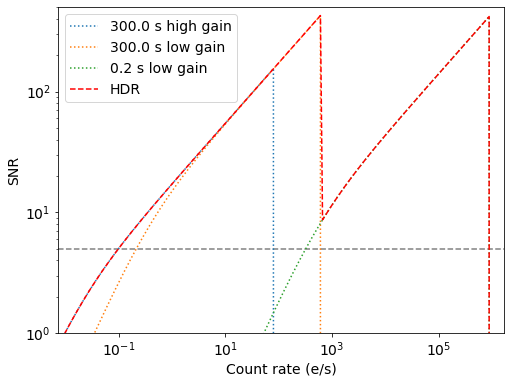

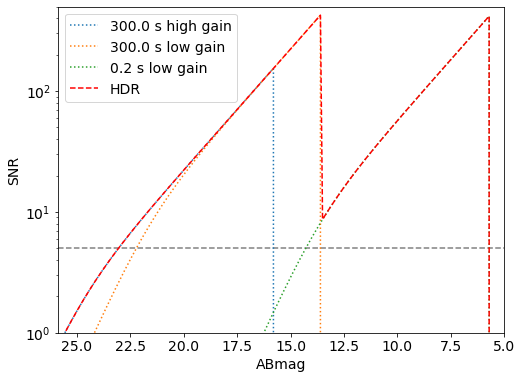

In [13]:
# HDR mode for long exposure, low mode for short exposure
b = 'fuv'
mags = np.arange(5,26,0.1) * u.ABmag
count_rate = magnitude_to_count_rate(mags, band=b)
cr_psf = count_rate / 4
e_rate = count_rate_to_electron_rate(cr_psf)

gains = ['high','low','low']
sorting = np.array([2,1,0]) # A little hack to make sure exposures are sorted in the order we want
exp_time = [300.,300.,0.2] * u.s

signals = np.zeros((len(gains),len(cr_psf)))
saturated = np.full((len(gains),len(cr_psf)), False)
snr = np.zeros((len(gains),len(cr_psf)))
for i, g in enumerate(gains):
    sig, sat = get_signal(cr_psf, [exp_time[i]], gain_mode=g)
    s = get_snr(cr_psf, [exp_time[i]], band=b, gain_mode=g)
    
    signals[i] = sig
    saturated[i] = sat
    snr[i] = s

hdr_snr = perform_hdr_simple(snr, saturated, sorting)

# Plot input magnitude vs SNR
plt.figure(figsize=[8,6])
plt.loglog()
plt.hlines(5,e_rate[-1].value,e_rate[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(e_rate,snr[i],ls='dotted',label='{} {} gain'.format(exp_time[i], g))
plt.plot(e_rate,hdr_snr,ls='--',label='HDR',color='red')
plt.legend()
plt.xlabel('Count rate (e/s)')
plt.ylabel('SNR')
plt.xlim([e_rate[-1].value,e_rate[0].value])
plt.ylim([1,500])
plt.savefig('plots/hdr_300sdual_02slow.pdf')
plt.show()

# Plot input magnitude vs SNR
plt.figure(figsize=[8,6])
plt.semilogy()
plt.hlines(5,mags[-1].value,mags[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(mags,snr[i],ls='dotted',label='{} {} gain'.format(exp_time[i], g))
plt.plot(mags,hdr_snr,ls='--',label='HDR',color='red')
plt.legend()
plt.xlabel('ABmag')
plt.ylabel('SNR')
plt.xlim([mags[-1].value,mags[0].value])
plt.ylim([1,500])
plt.savefig('plots/hdr_300sdual_02slow_mags.pdf')
plt.show()

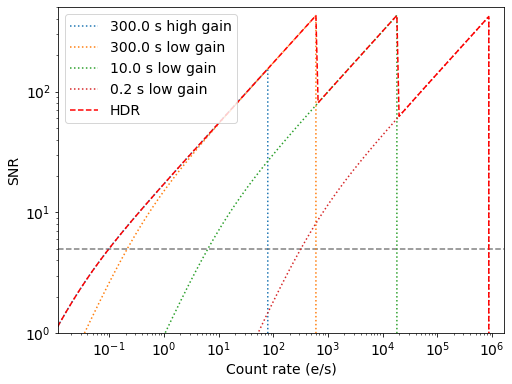

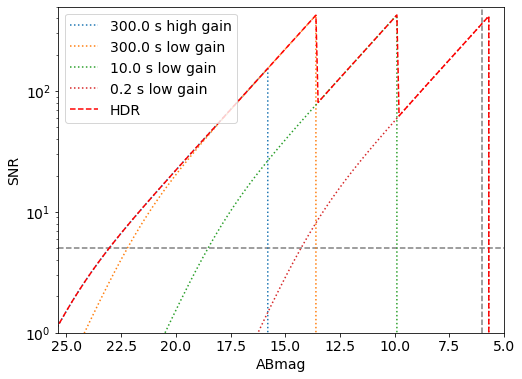

In [16]:
# HDR mode for long exposure, low mode for short exposure
b = 'fuv'
mags = np.arange(5,25.5,0.1) * u.ABmag
count_rate = magnitude_to_count_rate(mags, band=b)
cr_psf = count_rate / 4
e_rate = count_rate_to_electron_rate(cr_psf)

gains = ['high','low','low','low']
exp_time = [300.,300.,10.,0.2] * u.s

signals = np.zeros((len(gains),len(cr_psf)))
saturated = np.full((len(gains),len(cr_psf)), False)
snr = np.zeros((len(gains),len(cr_psf)))
for i, g in enumerate(gains):
    sig, sat = get_signal(cr_psf, [exp_time[i]], gain_mode=g)
    s = get_snr(cr_psf, [exp_time[i]], band=b, gain_mode=g)
    
    signals[i] = sig
    saturated[i] = sat
    snr[i] = s

hdr_snr = perform_hdr_simple(snr, saturated, exp_time)

# Plot input magnitude vs SNR
plt.figure(figsize=[8,6])
plt.loglog()
plt.hlines(5,e_rate[-1].value,e_rate[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(e_rate,snr[i],ls='dotted',label='{} {} gain'.format(exp_time[i], g))
plt.plot(e_rate,hdr_snr,ls='--',label='HDR',color='red')
plt.legend(loc=2)
plt.xlabel('Count rate (e/s)')
plt.ylabel('SNR')
plt.xlim([e_rate[-1].value,e_rate[0].value])
plt.ylim([1,500])
plt.savefig('plots/hdr_300sdual_10slow_02slow.pdf')
plt.show()

plt.figure(figsize=[8,6])
plt.semilogy()
plt.vlines(6,1,500,color='grey',ls='--')
plt.hlines(5,mags[-1].value,mags[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(mags,snr[i],ls='dotted',label='{} {} gain'.format(exp_time[i], g))
plt.plot(mags,hdr_snr,ls='--',label='HDR',color='red')
plt.legend(loc=2)
plt.xlabel('ABmag')
plt.ylabel('SNR')
plt.xlim([mags[-1].value,mags[0].value])
plt.ylim([1,500])
plt.savefig('plots/hdr_300sdual_10slow_02slow_mags.pdf')
plt.show()

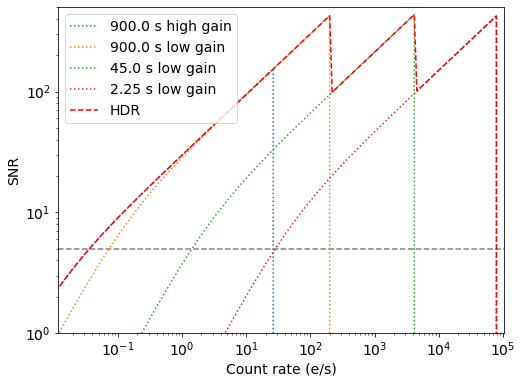

In [33]:
# HDR mode for long exposure, low mode for short exposure
b = 'fuv'
mags = np.arange(8,25.5,0.1) * u.ABmag
count_rate = magnitude_to_count_rate(mags, band=b)
cr_psf = count_rate / 4
e_rate = count_rate_to_electron_rate(cr_psf)

gains = ['high','low','low','low']
exp_time = [900.,900.,45., 2.25] * u.s

signals = np.zeros((len(gains),len(cr_psf)))
saturated = np.full((len(gains),len(cr_psf)), False)
snr = np.zeros((len(gains),len(cr_psf)))
for i, g in enumerate(gains):
    sig, sat = get_signal(cr_psf, [exp_time[i]], gain_mode=g)
    s = get_snr(cr_psf, [exp_time[i]], band=b, gain_mode=g)
    
    signals[i] = sig
    saturated[i] = sat
    snr[i] = s

hdr_snr = perform_hdr_simple(snr, saturated, exp_time)

# Plot input magnitude vs SNR
plt.figure(figsize=[8,6])
plt.loglog()
plt.hlines(5,e_rate[-1].value,e_rate[0].value,color='grey',ls='--')
for i, g in enumerate(gains):
    plt.plot(e_rate,snr[i],ls='dotted',label='{} {} gain'.format(exp_time[i], g))
plt.plot(e_rate,hdr_snr,ls='--',label='HDR',color='red')
plt.legend(loc=2)
plt.xlabel('Count rate (e/s)')
plt.ylabel('SNR')
plt.xlim([e_rate[-1].value,e_rate[0].value])
plt.ylim([1,500])
plt.savefig('plots/hdr_900sdual_45slow_2.25slow.pdf')
plt.show()